In [1]:
import os; os.environ["CONDA_PREFIX"] = "/opt/conda"
!pip install -U -q uv
!uv pip install modAL-python torchvision torchmetrics mlxtend torchsummary scikit-learn-intelex

Resolved 46 packages in 346ms
Downloaded 15 packages in 1.22s
Installed 15 packages in 95ms
 - contourpy==1.2.0
 - contourpy==1.2.1 (from file:///home/conda/feedstock_root/build_artifacts/contourpy_1712429905637/work)
 + contourpy==1.2.0
 - fonttools==4.47.0
 - fonttools==4.51.0 (from file:///home/conda/feedstock_root/build_artifacts/fonttools_1712344558731/work)
 + fonttools==4.47.0
 - fsspec==2024.2.0
 - fsspec==2024.3.1 (from file:///home/conda/feedstock_root/build_artifacts/fsspec_1710808267764/work)
 + fsspec==2024.2.0
 - markupsafe==2.1.5
 - markupsafe==2.1.3 (from file:///home/conda/feedstock_root/build_artifacts/markupsafe_1695367434228/work)
 + markupsafe==2.1.5
 - matplotlib==3.7.5
 - matplotlib==3.8.4 (from file:///home/conda/feedstock_root/build_artifacts/matplotlib-suite_1712605966339/work)
 + matplotlib==3.7.5
 + modal-python==0.4.2.1
 - pandas==2.1.4
 - pandas==2.2.2
 + pandas==2.2.2
 - pillow==9.5.0
 - pillow==10.3.0 (from file:///home/conda/feedstock_root/build_artifac

In [2]:
import random
from pathlib import Path
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import mlxtend
import numpy as np
import requests
import torch
import torchvision
import torchvision.models as models
from mlxtend.plotting import plot_confusion_matrix
from modAL.models import ActiveLearner
from modAL.uncertainty import entropy_sampling, margin_sampling, uncertainty_sampling
from skorch import NeuralNetClassifier
from torch import nn
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix, F1Score, Precision, Recall
from torchsummary import summary
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm.auto import tqdm
from sklearnex import patch_sklearn

patch_sklearn()
print(f"mlxtend version: {mlxtend.__version__}")
print("torch", torch.__version__)
print("torchvision", torchvision.__version__)
print("CUDA available:", torch.cuda.is_available())
print("GPU List:", torch.cuda.device_count())
print("Current Device:", torch.cuda.current_device())

mlxtend version: 0.23.1
torch 2.1.2
torchvision 0.16.2
CUDA available: True
GPU List: 1
Current Device: 0


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# We will use the Cifar 101 data set as our first dataset


In [3]:
cifar_train_data = datasets.CIFAR10(
    root="data", train=True, download=True, transform=ToTensor(), target_transform=None
)

cifar_test_data = datasets.CIFAR10(
    root="data", train=False, download=True, transform=ToTensor(), target_transform=None
)

# DataLoader
train_loader = DataLoader(cifar_train_data, batch_size=50000, shuffle=True)
test_loader = DataLoader(cifar_test_data, batch_size=10000, shuffle=True)

# DataLoader to NumPy
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))

x_train = x_train.numpy()
y_train = y_train.numpy()
x_test = x_test.numpy()
y_test = y_test.numpy()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

100%|██████████| 170498071/170498071 [00:03<00:00, 45030793.10it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Using cuda device


In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 3, 32, 32), (50000,), (10000, 3, 32, 32), (10000,))

In [5]:
len(cifar_train_data), len(cifar_test_data)

(50000, 10000)

In [6]:
cifar_class_names = cifar_train_data.classes
cifar_class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
class_to_idx_cif = cifar_train_data.class_to_idx
class_to_idx_cif

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
image, label = cifar_train_data[0]
image, label

(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
          [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
          [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
          ...,
          [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
          [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
          [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],
 
         [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
          [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
          [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
          ...,
          [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
          [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
          [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],
 
         [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
          [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
          [0.0824, 0.0000, 0.0314,  ...,

In [9]:
torch.tensor(cifar_train_data.targets)

tensor([6, 9, 9,  ..., 9, 1, 1])

In [10]:
torch.tensor(cifar_train_data.targets).shape

torch.Size([50000])

In [11]:
print(
    f"Image Shape: {image.shape} -> [color channels, height, width]"
)  # Our images are gray_scale!
print(f"Label: {cifar_class_names[label]}")

Image Shape: torch.Size([3, 32, 32]) -> [color channels, height, width]
Label: frog


(-0.5, 31.5, 31.5, -0.5)

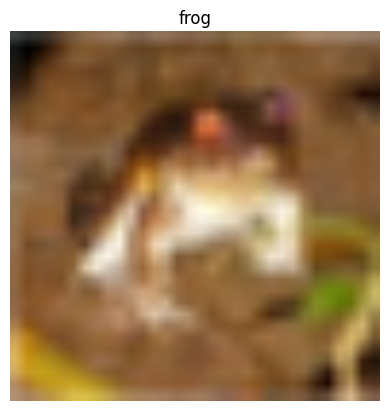

In [12]:
image = image.permute(1, 2, 0).numpy()
plt.imshow(image, interpolation="bilinear")
plt.title(cifar_class_names[label])
plt.axis(False)

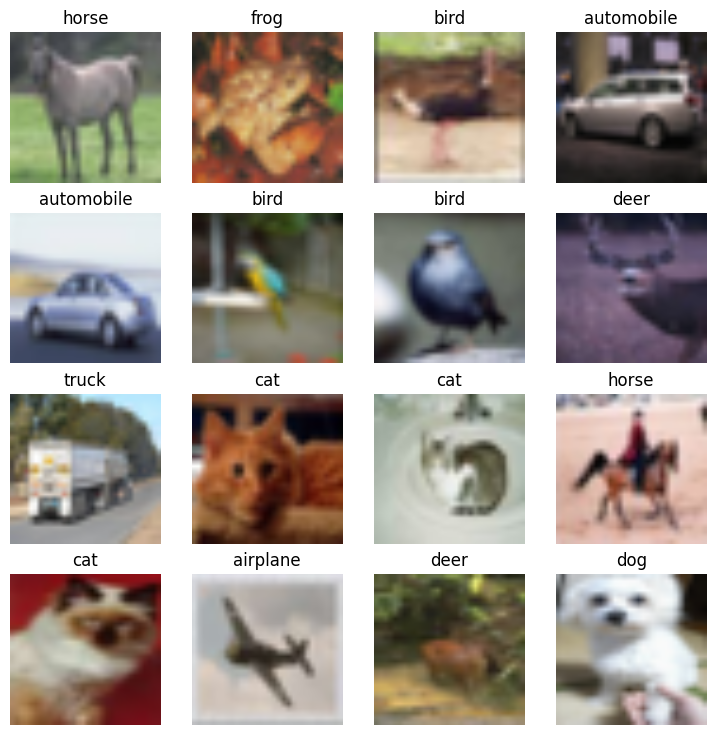

In [13]:
# Show more images
plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows * cols + 1):
    random_index = torch.randint(1, len(cifar_train_data), size=[1]).item()
    plt.subplot(rows, cols, i)
    image, label = cifar_train_data[random_index]
    image = image.permute(1, 2, 0).numpy()
    plt.imshow(image, interpolation="bilinear")
    plt.title(cifar_class_names[label])
    plt.axis(False)

plt.show()

# Unlabeling The Dataset


In [14]:
# Define the percentage of data without labels
percentage_without_labels = 0.8

# Calculate the number of samples without labels
num_samples_without_labels = int(len(cifar_train_data) * percentage_without_labels)
num_samples_with_labels = len(cifar_train_data) - num_samples_without_labels

# Create indices for data with labels and without labels
indices_without_labels = np.random.choice(
    range(len(cifar_train_data)), size=num_samples_without_labels, replace=False
)

indices_with_labels = np.array(
    [i for i in range(len(cifar_train_data)) if i not in indices_without_labels]
)

x_initial = x_train[indices_with_labels]
y_initial = y_train[indices_with_labels]

# generate the pool
# remove the initial data from the training dataset
x_pool = np.delete(x_train, indices_with_labels, axis=0)
y_pool = np.delete(y_train, indices_with_labels, axis=0)

In [15]:
x_initial.shape, y_initial.shape, x_pool.shape, y_pool.shape

((10000, 3, 32, 32), (10000,), (40000, 3, 32, 32), (40000,))

In [16]:
len(cifar_train_data)

50000

In [17]:
cifar_train_data[1][1]

9

# Creating the DataLoaders


In [18]:
BATCH_SIZE_CIF = 32

cifar_train_data_loader = DataLoader(cifar_train_data, BATCH_SIZE_CIF, shuffle=True)
cifar_test_data_loader = DataLoader(cifar_test_data, BATCH_SIZE_CIF, shuffle=False)

In [19]:
cifar_train_data_loader, cifar_test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7875c0996ef0>,
 <torch.utils.data.dataloader.DataLoader at 0x7876a6a577c0>)

In [20]:
print(
    f"Length of Training Data loader: {len(cifar_train_data_loader)}, Batches of {cifar_train_data_loader.batch_size}"
)
print(
    f"Length of Testing Data loader: {len(cifar_test_data_loader)}, Batches of {cifar_test_data_loader.batch_size}"
)

Length of Training Data loader: 1563, Batches of 32
Length of Testing Data loader: 313, Batches of 32


In [21]:
train_features_batch_cif, train_labels_batch_cif = next(iter(cifar_train_data_loader))
(
    train_features_batch_cif.shape,
    train_labels_batch_cif.shape,
)  # [Batch_Size, Color_Channels, Height, Width] Color Channels First!

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

(-0.5, 31.5, 31.5, -0.5)

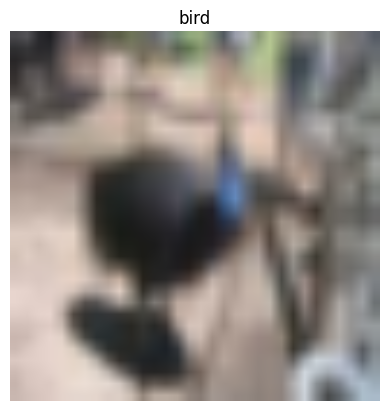

In [22]:
# Visualizing Images in the batch
random_idx = torch.randint(0, len(train_features_batch_cif), size=[1]).item()

img, label = train_features_batch_cif[random_idx], train_labels_batch_cif[random_idx]
img = img.permute(1, 2, 0).numpy()
plt.imshow(img, interpolation="bilinear")
plt.title(cifar_class_names[label])
plt.axis(False)

# Importing and Using ResNet 50 Architecture


In [23]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [24]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)
next(model.parameters()).device

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 164MB/s]


device(type='cpu')

In [25]:
f = nn.Flatten(start_dim=0)  # The default start dim is 1
x = f(torch.randn(10, 7, 7))
x.size()

torch.Size([490])

In [26]:
rand_image_tensor = torch.randn(size=(32, 3, 32, 32))

In [27]:
rand_image_tensor.device

device(type='cpu')

In [28]:
model(rand_image_tensor)

tensor([[ 0.1062, -0.3775, -0.2417,  0.0434, -0.0266, -0.1062, -0.0485, -0.1530,
         -0.1007,  0.0062],
        [ 0.1554, -0.1524, -0.0550, -0.2234, -0.2973,  0.0910, -0.1813,  0.2119,
         -0.3713, -0.2463],
        [ 0.6829, -0.5607,  0.0928, -0.3924, -0.3579,  0.1040, -0.1260,  0.6403,
          0.6071,  0.0683],
        [-0.1070, -0.0435,  0.3120, -0.0937, -0.4239,  0.6461, -0.0809, -0.3256,
          0.0099, -0.1707],
        [ 0.6249,  0.0983, -1.0473,  1.0044, -0.8118,  0.6192,  0.2577, -1.0008,
         -0.3728, -0.4117],
        [ 0.0608, -0.3062, -0.0545, -0.4368,  0.0089,  0.1297, -0.0020, -0.1014,
          0.0721,  0.0720],
        [ 0.4674, -0.6308,  0.1273, -0.0455,  0.1281,  0.3120,  0.0567,  0.1712,
          0.3215, -0.0412],
        [ 0.2078, -0.2950, -0.4935, -0.2096, -0.1657,  0.0395,  0.0610, -0.0616,
         -0.0568,  0.6700],
        [ 0.2665, -0.3807,  0.3550,  0.0338, -0.4284,  0.7219, -0.3359, -0.2259,
         -0.4345,  0.5407],
        [-0.1531,  

In [29]:
model.to(device)
next(model.parameters()).device

device(type='cuda', index=0)

# Printing the Architecture and Number of Trianing Parameters in each Layer


In [30]:
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

# External Helper Functions


In [31]:
if Path("HelperFunctions.py").is_file():
    print("Helper Functions already exists, skipping downloading")
else:
    print("downloading HelperFunctions.py")
    request = requests.get(
        "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    )
    with open("HelperFunctions.py", "wb") as f:
        f.write(request.content)

downloading HelperFunctions.py


In [32]:
# Picking a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [33]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = correct / len(y_true) * 100
    return accuracy

In [34]:
def display_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on device {device}: {total_time:.3f} seconds")
    return total_time

In [35]:
start = timer()
end = timer()
display_train_time(start, end, device="cpu")

Train time on device cpu: 0.000 seconds


2.8092999968976073e-05

In [36]:
def train_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
    device: torch.device = device,
):
    training_loss = 0
    training_acc = 0
    model.train()

    for batch, (x, y) in enumerate(data_loader):
        # Put the data on the target device
        x, y = x.to(device), y.to(device)
        # Forward Pass
        y_pred = model(x)
        # Loss
        loss = loss_fn(y_pred, y)
        training_loss += loss
        training_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        # Optimizer zero grad
        optimizer.zero_grad()
        # Loss Backward
        loss.backward()
        # optimizer step step step
        optimizer.step()
    # After looping over batches, divide the training loss over the number of batches to get the average loss per batch
    training_loss /= len(
        data_loader
    )  # train.data_loader (returns the number of batches)
    training_acc /= len(data_loader)
    print(
        f"Training Loss: {training_loss:.5f} | Training Accuracy: {training_acc:.2f}%"
    )

In [37]:
def test_step(
    model: nn.Module,
    data_loader: torch.utils.data.dataloader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    testing_acc = 0
    testing_loss = 0
    model.eval()

    with torch.inference_mode():
        for x, y in data_loader:
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_test_pred = model(x)
            # Loss
            testing_loss += loss_fn(y_test_pred, y)
            # Accuracy
            testing_acc += accuracy_fn(y_test_pred.argmax(dim=1), y)
        testing_loss /= len(data_loader)
        testing_acc /= len(data_loader)
    print(f"Testing Loss: {testing_loss:.3f} | Testing Accuracy: {testing_acc:.2f}%")

In [38]:
!nvidia-smi

Mon Apr 29 16:24:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla P100-PCIE-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0              30W / 250W |    456MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [39]:
# Set the seed and start the timer
torch.manual_seed(42)
torch.cuda.manual_seed(42)
train_start_time_on_gpu = timer()
# Set the number of epochs
epochs = 20
# Training
for epoch in tqdm(range(epochs)):
    print(f"\nepoch: {epoch+1}\n--------------------------------------")
    # Training
    train_step(model, cifar_train_data_loader, loss_fn, optimizer, accuracy_fn, device)
    # Testing
    test_step(model, cifar_test_data_loader, loss_fn, accuracy_fn, device)
# Compute the time of the training
print("\nTraining is finished!\n")
train_end_time_on_gpu = timer()
display_train_time(
    train_start_time_on_gpu,
    train_end_time_on_gpu,
    device=next(model.parameters()).device,
)

  0%|          | 0/20 [00:00<?, ?it/s]


epoch: 1
--------------------------------------
Training Loss: 2.00372 | Training Accuracy: 28.98%
Testing Loss: 1.633 | Testing Accuracy: 39.58%

epoch: 2
--------------------------------------
Training Loss: 1.50073 | Training Accuracy: 45.62%
Testing Loss: 1.493 | Testing Accuracy: 48.48%

epoch: 3
--------------------------------------
Training Loss: 1.30503 | Training Accuracy: 53.69%
Testing Loss: 1.471 | Testing Accuracy: 47.66%

epoch: 4
--------------------------------------
Training Loss: 1.16284 | Training Accuracy: 59.31%
Testing Loss: 1.322 | Testing Accuracy: 54.84%

epoch: 5
--------------------------------------
Training Loss: 1.03194 | Training Accuracy: 64.03%
Testing Loss: 1.395 | Testing Accuracy: 54.56%

epoch: 6
--------------------------------------
Training Loss: 0.93074 | Training Accuracy: 67.74%
Testing Loss: 0.965 | Testing Accuracy: 66.32%

epoch: 7
--------------------------------------
Training Loss: 0.85651 | Training Accuracy: 70.60%
Testing Loss: 1.02

1226.876349894

In [40]:
torch.manual_seed(42)

In [41]:
def eval_model(
    model: nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
    device: torch.device = device,
):
    model.eval()
    loss, acc = 0, 0

    with torch.inference_mode():
        for x, y in tqdm(data_loader):
            x, y = x.to(device), y.to(device)
            # Forward Pass
            y_pred = model(x)
            # Loss
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(torch.argmax(y_pred, dim=1), y)
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {
        "Model Name": model.__class__.__name__,
        "Model Loss": loss.item(),
        "Model Accuracy": acc,
    }, torch.argmax(y_pred, dim=1)

In [42]:
# Testing the model
cifar_model_results, y_pred = eval_model(
    model, cifar_test_data_loader, loss_fn, accuracy_fn
)

  0%|          | 0/313 [00:00<?, ?it/s]

In [43]:
cifar_model_results, y_pred

({'Model Name': 'ResNet',
  'Model Loss': 0.9064211845397949,
  'Model Accuracy': 74.04153354632588},
 tensor([7, 5, 0, 0, 8, 4, 7, 0, 3, 3, 3, 3, 5, 5, 1, 7], device='cuda:0'))

In [44]:
len(next(iter(cifar_test_data_loader)))

2

# Evaluating Model Visually


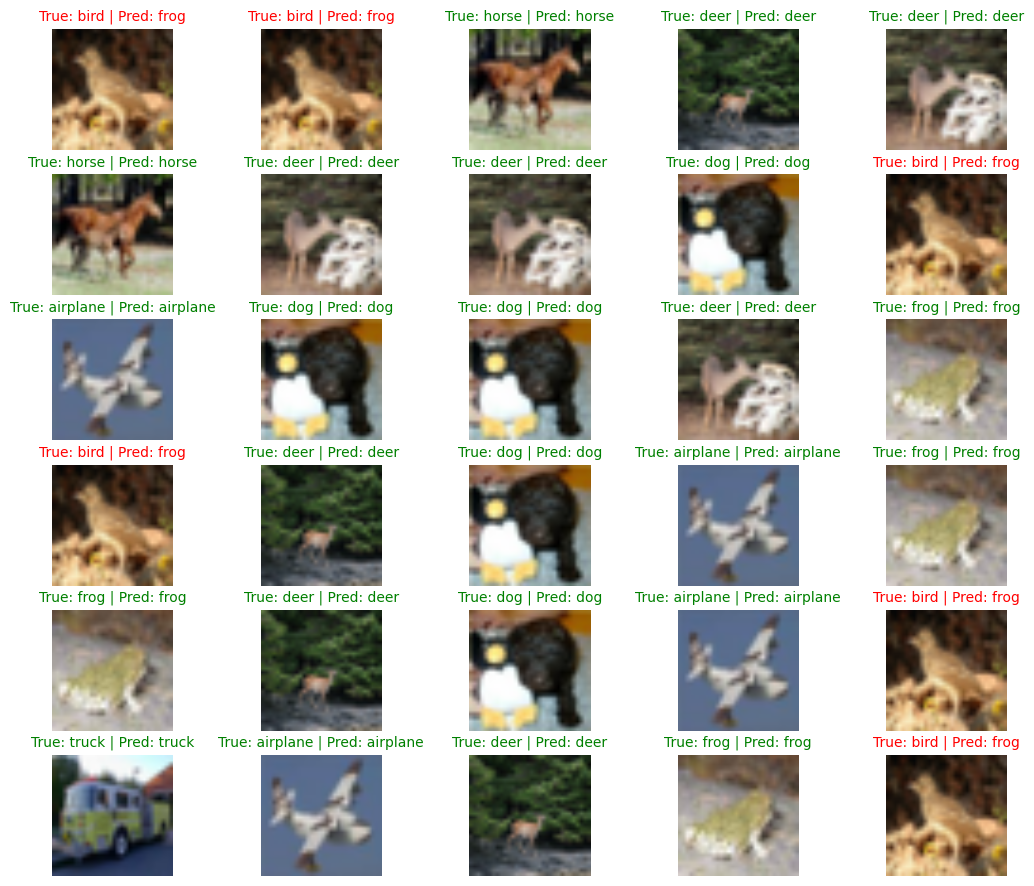

In [45]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(cifar_test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

rows = 6
cols = 5

plt.figure(figsize=(13, 11))

model.eval()
with torch.inference_mode():
    for i in range(1, rows * cols + 1):
        plt.subplot(rows, cols, i)
        random_index = torch.randint(1, 9, size=[1]).item()
        image, label = test_samples[random_index], test_labels[random_index]
        pred_label = model(image.unsqueeze(dim=0).to(device)).argmax()
        image = image.permute(1, 2, 0).numpy()
        plt.imshow(image, interpolation="bilinear")
        if pred_label == label:
            plt.title(
                f"True: {cifar_class_names[label]} | Pred: {cifar_class_names[pred_label]}",
                c="g",
                fontsize=10,
            )
        else:
            plt.title(
                f"True: {cifar_class_names[label]} | Pred: {cifar_class_names[pred_label]}",
                c="r",
                fontsize=10,
            )
        plt.axis(False)

In [46]:
mlxtend.__version__.split(".")[1]

'23'

In [47]:
type(torch.tensor(cifar_test_data.targets)), type(y_pred)

(torch.Tensor, torch.Tensor)

In [48]:
y_preds = []
model.eval()

with torch.inference_mode():
    for x, y in tqdm(cifar_test_data_loader, desc="Making Predictions..."):
        # Send the data to the target device
        x, y = x.to(device), y.to(device)
        # Forward Pass
        logits = model(x)
        # Pred probs then labels
        y_pred = torch.softmax(logits, dim=1).argmax(dim=1)
        # Put predictions on the cpu for evaluation
        y_preds.append(y_pred.cpu())
# Concatenate the predicions of all batches
y_pred_tensor = torch.cat(y_preds)

Making Predictions...:   0%|          | 0/313 [00:00<?, ?it/s]

In [49]:
# Initialize precision, recall, and F1 score metrics
precision = Precision(task="multiclass", num_classes=len(cifar_class_names))
recall = Recall(task="multiclass", num_classes=len(cifar_class_names))
f1 = F1Score(task="multiclass", num_classes=len(cifar_class_names))
# Update the metrics with true and predicted labels
precision.update(y_pred_tensor, torch.tensor(cifar_test_data.targets))
recall.update(y_pred_tensor, torch.tensor(cifar_test_data.targets))
f1.update(y_pred_tensor, torch.tensor(cifar_test_data.targets))
# Compute the metrics
precision_result = precision.compute()
recall_result = recall.compute()
f1_result = f1.compute()

print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")
print(f"F1 Score: {f1_result}")

Precision: 0.7404999732971191
Recall: 0.7404999732971191
F1 Score: 0.7404999732971191


In [50]:
len(y_pred_tensor)

10000

In [51]:
confmat = ConfusionMatrix(task="multiclass", num_classes=len(cifar_class_names))
confmat_tensor = confmat(
    preds=y_pred_tensor, target=torch.tensor(cifar_test_data.targets)
)

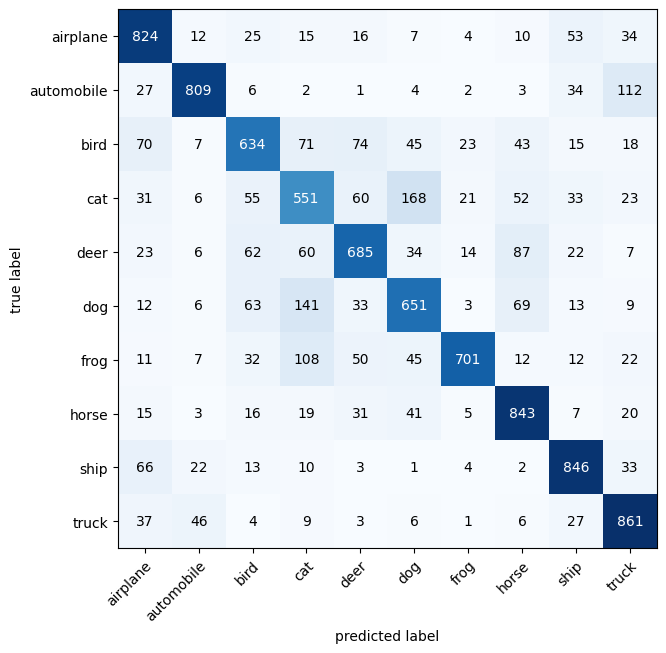

In [52]:
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),  # Matplotlib likes working with numpy!
    class_names=cifar_class_names,
    figsize=(10, 7),
)

# Saving the Model


In [53]:
# Create the models path
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(parents=True, exist_ok=True)
# Create model save
MODEL_NAME = "base_model.pth"
MODEL_SAVE_PATH = MODELS_PATH / MODEL_NAME
# Save the model
print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models/base_model.pth


# Load the Model


In [54]:
# Create a model instance
trained_model = models.resnet50().to(device)
trained_model.fc = nn.Linear(model.fc.in_features, 10)
trained_model.load_state_dict(torch.load(MODEL_SAVE_PATH))
trained_model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [55]:
summary(trained_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [56]:
trained_model = NeuralNetClassifier(
    trained_model,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    train_split=None,
    verbose=1,
    device=device,
)

# Active Learning


In [57]:
def active_learning(pool_x, pool_y, method, model):
    learner = None
    cycles = 10
    queried_instance = []
    queried_index = []
    queried_label = []
    if method == "uncertainty_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=x_initial,
            y_training=y_initial,
            query_strategy=uncertainty_sampling,
        )
    elif method == "margin_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=x_initial,
            y_training=y_initial,
            query_strategy=margin_sampling,
        )
    elif method == "entropy_sampling":
        learner = ActiveLearner(
            estimator=model,
            X_training=x_initial,
            y_training=y_initial,
            query_strategy=entropy_sampling,
        )
    print(f"Starting Active Learning with {method} method")
    for cycle in range(cycles):
        print(f"\nCycle: {cycle+1}")
        query_idx, query_instance = learner.query(pool_x)
        learner.teach(X=pool_x[query_idx], y=pool_y[query_idx])
        # save queried instance, index and label
        queried_instance.append(query_instance)
        queried_index.append(query_idx)
        queried_label.append(pool_y[query_idx])
        # remove queried instance from pool_x
        pool_x = np.delete(pool_x, query_idx, axis=0)
        pool_y = np.delete(pool_y, query_idx, axis=0)
    return queried_instance, queried_index, queried_label, learner

In [58]:
queried_instance, queried_index, queried_label, learner = active_learning(
    x_pool, y_pool, "uncertainty_sampling", trained_model
)

  epoch    train_loss     dur
-------  ------------  ------
      1        0.1232  7.7520
      2        0.0302  7.6789
      3        0.0291  7.6775
      4        0.0223  7.6829
      5        0.0058  7.7047
      6        0.0017  7.6824
      7        0.0008  7.6927
      8        0.0003  7.6855
      9        0.0002  7.7261
     10        0.0001  7.6762
Starting Active Learning with uncertainty_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0235  7.7118
      2        0.0379  7.6771
      3        0.0258  7.6586
      4        0.0090  7.6536
      5        0.0039  7.6513
      6        0.0006  7.6856
      7        0.0002  7.7031
      8        0.0001  7.6627
      9        0.0001  7.7264
     10        0.0001  7.7771

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0142  7.7857
      2        0.0600  7.6844
      3        0.0237  7.715

Precision: 0.7501
Recall: 0.7501
F1 Score: 0.7501
Accuracy: 0.7501


(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

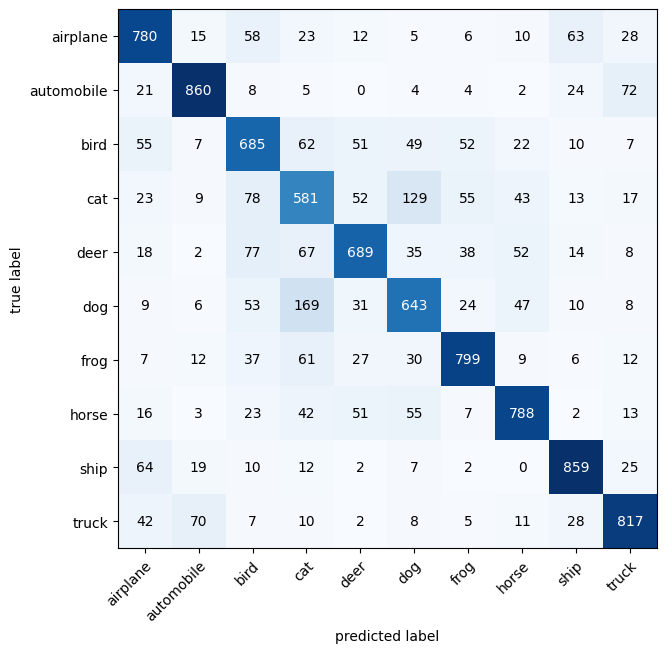

In [59]:
y_pred = learner.predict(x_test)
# Initialize precision, recall, and F1 score metrics
precision = Precision(task="multiclass", num_classes=len(cifar_class_names))
recall = Recall(task="multiclass", num_classes=len(cifar_class_names))
f1 = F1Score(task="multiclass", num_classes=len(cifar_class_names))
confusion_matrix = ConfusionMatrix(
    task="multiclass", num_classes=len(cifar_class_names)
)
# Update the metrics with true and predicted labels
precision.update(torch.tensor(y_pred), torch.tensor(y_test))
recall.update(torch.tensor(y_pred), torch.tensor(y_test))
f1.update(torch.tensor(y_pred), torch.tensor(y_test))
confusion_matrix.update(torch.tensor(y_pred), torch.tensor(y_test))
# Compute the metrics
precision_result = precision.compute()
recall_result = recall.compute()
f1_result = f1.compute()
confusion_matrix.compute()
# Print the metrics
print(f"Precision: {precision_result:.4f}")
print(f"Recall: {recall_result:.4f}")
print(f"F1 Score: {f1_result:.4f}")
print(f"Accuracy: {learner.score(x_test, y_test)}")
plot_confusion_matrix(
    conf_mat=confusion_matrix.compute().numpy(),
    class_names=cifar_class_names,
    figsize=(10, 7),
)

In [60]:
queried_instance, queried_index, queried_label, learner = active_learning(
    x_pool, y_pool, "margin_sampling", trained_model
)

Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0182  7.7600
      2        0.0303  7.7859
      3        0.0200  7.7825
      4        0.0088  7.7706
      5        0.0023  7.7894
      6        0.0036  7.7708
      7        0.0011  7.7698
      8        0.0063  7.7603
      9        0.0032  7.7739
     10        0.0209  7.7949
Starting Active Learning with margin_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0212  7.7711
      2        0.0344  7.7702
      3        0.0614  7.7569
      4        0.0073  7.7758
      5        0.0011  7.7621
      6        0.0002  7.7625
      7        0.0001  7.7676
      8        0.0001  7.7916
      9        0.0001  7.7860
     10        0.0000  7.7632

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0212  7.7921
      2        0.0304  7.7589
      

Precision: 0.7410
Recall: 0.7410
F1 Score: 0.7410
Accuracy: 0.741


(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

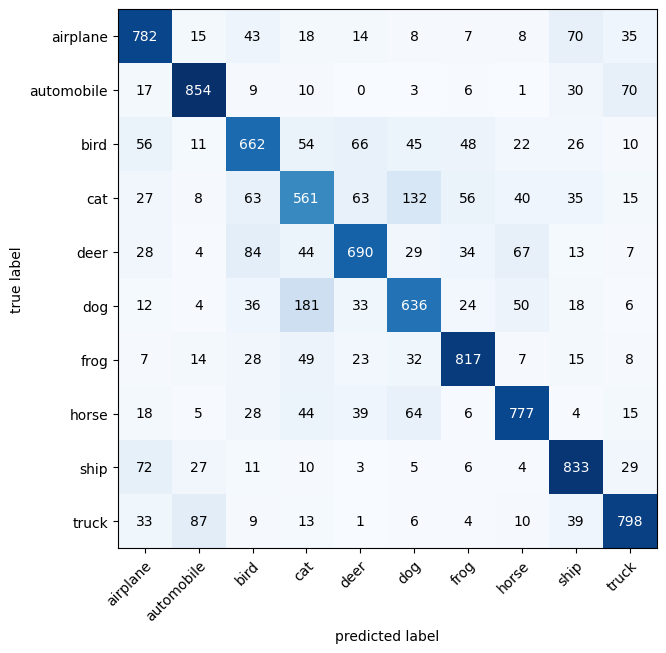

In [61]:
y_pred = learner.predict(x_test)
# Initialize precision, recall, and F1 score metrics
precision = Precision(task="multiclass", num_classes=len(cifar_class_names))
recall = Recall(task="multiclass", num_classes=len(cifar_class_names))
f1 = F1Score(task="multiclass", num_classes=len(cifar_class_names))
confusion_matrix = ConfusionMatrix(
    task="multiclass", num_classes=len(cifar_class_names)
)
# Update the metrics with true and predicted labels
precision.update(torch.tensor(y_pred), torch.tensor(y_test))
recall.update(torch.tensor(y_pred), torch.tensor(y_test))
f1.update(torch.tensor(y_pred), torch.tensor(y_test))
confusion_matrix.update(torch.tensor(y_pred), torch.tensor(y_test))
# Compute the metrics
precision_result = precision.compute()
recall_result = recall.compute()
f1_result = f1.compute()
confusion_matrix.compute()
# Print the metrics
print(f"Precision: {precision_result:.4f}")
print(f"Recall: {recall_result:.4f}")
print(f"F1 Score: {f1_result:.4f}")
print(f"Accuracy: {learner.score(x_test, y_test)}")
plot_confusion_matrix(
    conf_mat=confusion_matrix.compute().numpy(),
    class_names=cifar_class_names,
    figsize=(10, 7),
)

In [62]:
queried_instance, queried_index, queried_label, learner = active_learning(
    x_pool, y_pool, "entropy_sampling", trained_model
)

Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0106  7.8144
      2        0.0196  7.8295
      3        0.0119  7.8177
      4        0.0080  7.8237
      5        0.0062  7.8022
      6        0.0116  7.8243
      7        0.0138  7.8345
      8        0.0087  7.8258
      9        0.0010  7.8093
     10        0.0002  7.8051
Starting Active Learning with entropy_sampling method

Cycle: 1
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0148  7.8155
      2        0.0521  7.7967
      3        0.0034  7.8179
      4        0.0005  7.8125
      5        0.0001  7.8308
      6        0.0001  7.8091
      7        0.0000  7.8251
      8        0.0000  7.8197
      9        0.0000  7.8181
     10        0.0000  7.7947

Cycle: 2
Re-initializing optimizer.
  epoch    train_loss     dur
-------  ------------  ------
      1        0.0107  7.8233
      2        0.0196  7.8312
     

Precision: 0.7381
Recall: 0.7381
F1 Score: 0.7381
Accuracy: 0.7381


(<Figure size 1000x700 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

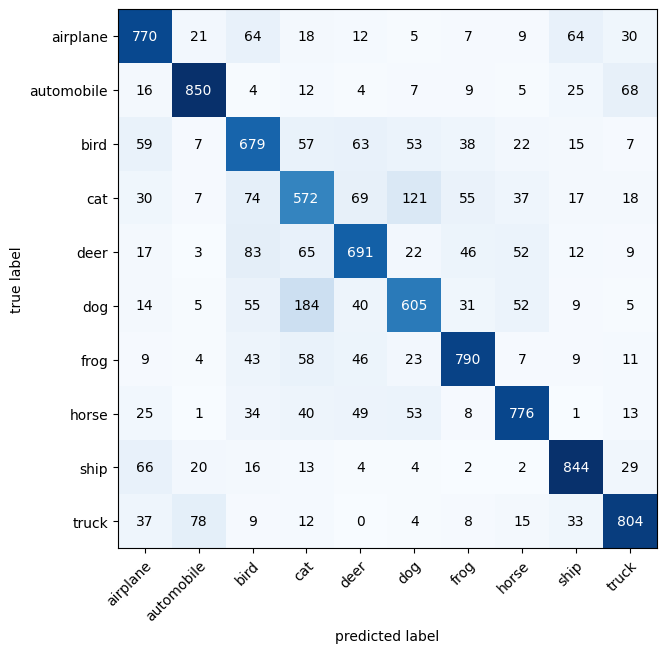

In [63]:
y_pred = learner.predict(x_test)
# Initialize precision, recall, and F1 score metrics
precision = Precision(task="multiclass", num_classes=len(cifar_class_names))
recall = Recall(task="multiclass", num_classes=len(cifar_class_names))
f1 = F1Score(task="multiclass", num_classes=len(cifar_class_names))
confusion_matrix = ConfusionMatrix(
    task="multiclass", num_classes=len(cifar_class_names)
)
# Update the metrics with true and predicted labels
precision.update(torch.tensor(y_pred), torch.tensor(y_test))
recall.update(torch.tensor(y_pred), torch.tensor(y_test))
f1.update(torch.tensor(y_pred), torch.tensor(y_test))
confusion_matrix.update(torch.tensor(y_pred), torch.tensor(y_test))
# Compute the metrics
precision_result = precision.compute()
recall_result = recall.compute()
f1_result = f1.compute()
confusion_matrix.compute()
# Print the metrics
print(f"Precision: {precision_result:.4f}")
print(f"Recall: {recall_result:.4f}")
print(f"F1 Score: {f1_result:.4f}")
print(f"Accuracy: {learner.score(x_test, y_test)}")
plot_confusion_matrix(
    conf_mat=confusion_matrix.compute().numpy(),
    class_names=cifar_class_names,
    figsize=(10, 7),
)